In [170]:
from jax import numpy as np
from jax import grad, jit, vmap
from jax.lax import conv
import numpy as onp
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
# import functools

## data

In [214]:
data_dir = 'data/architectural-styles-dataset'
classes = os.listdir(data_dir)
n_classes = 4
image_size = 64
ctoi = {c:i for i,c in enumerate(classes)}
files = {c: [f for f in os.listdir(os.path.join(data_dir, c)) if f.endswith('.jpg')] for c in classes}
rng = onp.random.RandomState(0)

In [215]:
def image_file_to_numpy_array(filename):
    x = Image.open(filename)
    w, h = x.size
    if w > h:
        x = x.crop(((w-h)//2, 0, (w+h)//2, h))
    elif h > w:
        x = x.crop((0, (h-w)//2, w, (h+w)//2))
    x = x.resize((image_size, image_size), Image.LANCZOS)
    x = np.array(x) / 255.  # normalize image
    if len(x.shape) == 2:  # ensure 3 channels
        x = np.repeat(x[:, :, np.newaxis], 3, axis=2)
    return x

def load_image_data(rng):
    X, Y = [], []
    for c in tqdm(classes[:n_classes]):
        for f in files[c]:
            X.append(image_file_to_numpy_array(os.path.join(data_dir, c, f)))
            Y.append(ctoi[c])
    shuffle_idx = rng.permutation(len(X))
    X = np.array(X)[shuffle_idx]
    Y = np.array(Y)[shuffle_idx]
    return X, Y


def get_batches(X, Y, batch_size=64):
    while True:
        shuffle_idx = onp.random.permutation(len(X))
        X = X[shuffle_idx]
        Y = Y[shuffle_idx]
        for i in range(0, len(X), batch_size):
            yield X[i:i+batch_size], Y[i:i+batch_size]

In [216]:
rng = onp.random.RandomState(0)
X, Y = load_image_data(rng)

100%|██████████| 4/4 [00:16<00:00,  4.23s/it]


In [217]:
rng = onp.random.RandomState(0)
train_idx, test_idx = onp.split(rng.permutation(len(X)), [int(.8*len(X))])
train_idx, val_idx = onp.split(train_idx, [int(.8*len(train_idx))])

X_train, Y_train = X[train_idx], Y[train_idx]
X_val, Y_val = X[val_idx], Y[val_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

train_batches = iter(get_batches(X_train, Y_train))
val_batches = iter(get_batches(X_val, Y_val))
test_batches = iter(get_batches(X_test, Y_test))

## mlp

In [218]:
rng = onp.random.RandomState(0)

In [219]:
def init_mlp(layer_sizes, rng):
    params = []
    for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
        w = rng.randn(n_in, n_out) * np.sqrt(2 / n_in)
        b = rng.randn(n_out) * np.sqrt(2 / n_in)
        params.append((w, b))
    return params

def softmax(x):
    exps = np.exp(x - x.max(axis=1, keepdims=True))
    return exps / exps.sum(axis=1, keepdims=True)

def predict_mlp(params, x):
    # x = x.mean(axis=3)  # average over color channels
    x = x.reshape(x.shape[0], -1)  # flatten
    activations = x
    for w, b in params:
        outputs = np.dot(activations, w) + b
        activations = np.tanh(outputs)
    return softmax(outputs)

def cross_entropy(params, x, y):
    y = np.eye(n_classes)[y]  # one-hot encode
    logits = predict_mlp(params, x)
    # multi class cross entropy (simple)
    return -np.sum(y * np.log(logits + 1e-12), axis=1).mean()

def update(params, grads, x, y, lr=0.001):
    grads = [(dw.mean(axis=0), db.mean(axis=0)) for dw, db in grads]
    return [(w - lr * dw, b - lr * db) for (w, b), (dw, db) in zip(params, grads)]


def accuracy(params, x, y):
    return np.mean(np.argmax(predict_mlp(params, x), axis=1) == y)


loss_fn = jit(cross_entropy)  # compiled loss evaluation function
grad_fn = jit(grad(cross_entropy))  # compiled gradient evaluation function

In [220]:
def evaluate(params, train_batches, val_batches):
    n = 10
    train_acc = 0
    val_acc = 0
    train_loss = 0
    val_loss = 0
    for i in range(n):
        x, y = next(train_batches)
        train_acc += accuracy(params, x, y).item()
        train_loss += loss_fn(params, x, y).item()
        x, y = next(val_batches)
        val_acc += accuracy(params, x, y).item()
        val_loss += loss_fn(params, x, y).item()
    return train_acc / n, val_acc / n, train_loss / n, val_loss / n


In [221]:
params = init_mlp([image_size*image_size*3, 300, 300, n_classes], rng)
metrics_lst = []
pbar = tqdm(range(2000))
for i in pbar:
    x, y = next(train_batches)
    y_hat = predict_mlp(params, x)
    loss = loss_fn(params, x, y)
    grads = grad_fn(params, x, y)
    params = update(params, grads, x, y)
    if i % 50 == 0:
        metrics = evaluate(params, train_batches, val_batches)
        metrics_lst.append(metrics)
        pbar.set_description(f"train acc: {metrics[0]:.3f}, val acc: {metrics[1]:.3f}, train loss: {metrics[2]:.3f}, val loss: {metrics[3]:.3f}")
        

train acc: 0.492, val acc: 0.331, train loss: 1.215, val loss: 1.344: 100%|██████████| 2000/2000 [02:20<00:00, 14.26it/s]


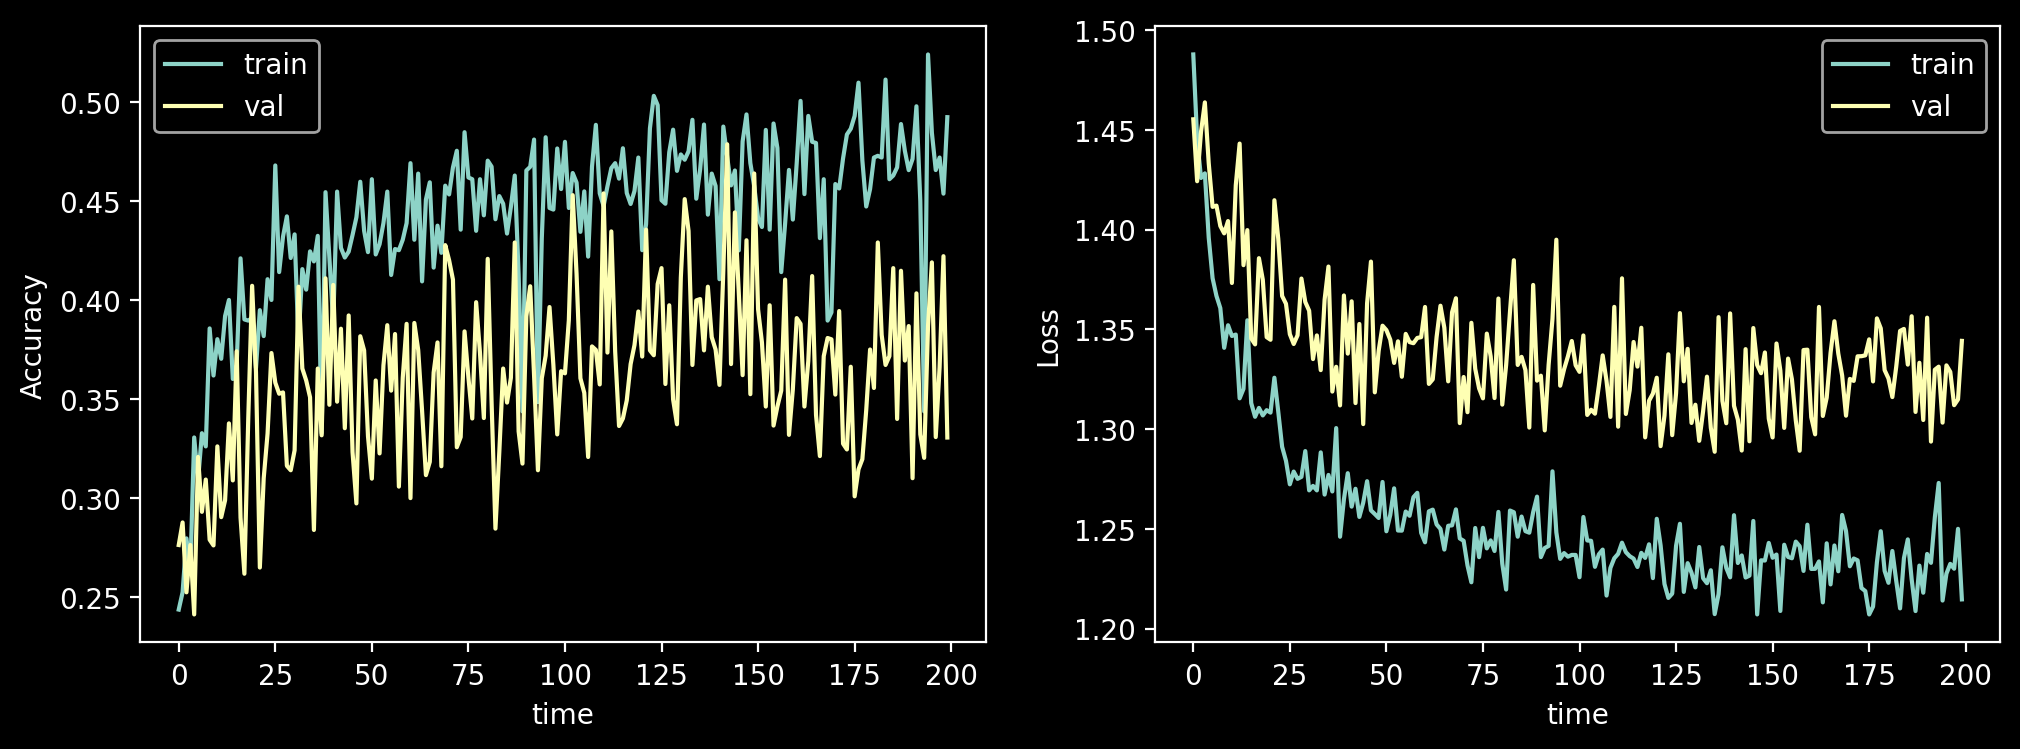

In [222]:
# black background
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=200)
plt.style.use('dark_background')
ax[0].plot([m[0] for m in metrics_lst], label='train')
ax[0].plot([m[1] for m in metrics_lst], label='val')
ax[0].set_xlabel('time')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[1].plot([m[2] for m in metrics_lst], label='train')
ax[1].plot([m[3] for m in metrics_lst], label='val')
ax[1].set_xlabel('time')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()